In [22]:
import os
import numpy as np
import pandas as pd
import h5py
import scipy
import matplotlib.pyplot as plt
from IPython.display import HTML
import re
import MDAnalysis as md
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis.base import (AnalysisBase, AnalysisFromFunction, analysis_class)
import math
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter


In [23]:
#For detector images
def bin_plane(xyz, plane_size, L, num_bins, detector_eff=1.0, axis=1):
    if detector_eff > 1.0:
        raise ValueError("Detector efficiency cannot be over 100%.")

    
    # Create the grid
    grid_range = np.linspace(-plane_size / 2, plane_size / 2, num_bins)
    
    if axis == 0:
        grid = np.array([(-L, x, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 2
    elif axis == 1:
        grid = np.array([(x, -L, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 0
        B2 = 2
    elif axis == 2:
        grid = np.array([(x, y, -L) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 0
    else:
        raise ValueError("Invalid axis value. Axis must be 0, 1, or 2.")
    
    # Filter out points that will never hit the plane based on their y-coordinate and the plane's location
    if L > 0:
        xyz = xyz[xyz[:, axis] < 0.0]  # Points above the plane when L > 0 will not hit
    elif L < 0:
        xyz = xyz[xyz[:, axis] > 0.0]  # Points below the plane when L < 0 will not hit

    # Calculate the hit locations on the plane
    k = -L / xyz[:, axis]
    hit_location = k[:, np.newaxis] * xyz

    # Initialize the bins
    bins = np.zeros((num_bins, num_bins), dtype=int)

    N = len(hit_location)
    M = int(detector_eff * N)
    
    keep_idx = np.random.choice(N, M, replace=False)
    hit_location = hit_location[keep_idx]

    count_hits = 0
    # Process each hit location
    for hit in hit_location:
        # Check if the hit is within the plane bounds
        if -plane_size / 2 <= hit[B1] <= plane_size / 2 and -plane_size / 2 <= hit[B2] <= plane_size / 2:
            # Find the closest grid point for the hit location
            distance = scipy.spatial.distance.cdist([hit], grid)
            closest_bin = np.argmin(distance)
            #count hits on plane
            count_hits +=1
            # Convert the linear index to 2D index and increment the corresponding bin
            y_idx, x_idx = divmod(closest_bin, num_bins)
            bins[y_idx, x_idx] += 1

    return bins.astype(np.int16), count_hits


#For sorting the lists
def extract_number(s):
    return int(''.join(filter(str.isdigit, s)))

#Normalization function
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

What dataset

In [24]:
efield = '5e4' #3e4 or 5e4
mds_folder = '' #This is meant to extract another simulation were 5e4 was runned more densly up to timestep 50. To see these results, put '_0to50'

# Taken from MDAnalysis webpage for "Writing your own trajectory analysis": https://userguide.mdanalysis.org/1.1.1/examples/analysis/custom_trajectory_analysis.html
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

cwd_long = f'/home/mans/E_{efield}'
E_folder = os.listdir(cwd_long) # ändra denna till mapp med samma fold!
print(E_folder)
all_runs = [i for i in E_folder if re.match(r'run\d+', i)]
all_runs = sorted(all_runs, key=extract_number)
print(all_runs)

#Get RoG
all_rog = []
for run in all_runs:
    u = md.Universe(f'{cwd_long}/{run}/long.gro', f'{cwd_long}/{run}/long.trr')
    protein = u.select_atoms('protein')
    idx = protein.indices

    rog = md.analysis.base.AnalysisFromFunction(radgyr, u.trajectory,
                            protein, protein.masses,
                            total_mass=np.sum(protein.masses))
    if mds_folder == '_0to50':
        rog.run(start=0, stop=501, step=5)
    else:
        rog.run(start=0, stop=1001, step=10)
    all_rog.append(rog)

print(len(all_rog))
print(all_rog[34].results['timeseries'].shape)

#Take specific RoG axis and add to flattened list
rog_list = []
labels = ['all', 'x-axis', 'y-axis', 'z-axis']

df_rog = pd.DataFrame(columns=labels)

for rog_run in range(len(all_runs)):
    for col, label in zip(all_rog[rog_run].results['timeseries'].T, labels):
        df_rog[label] = col
        if label == 'all':
            rog_list.append(col)

flattened_rog = np.concatenate(rog_list).tolist()
print(len(flattened_rog))

#mean RoG for 'all' label
rog_list = np.array(rog_list)
print(rog_list.shape)
mean_rog = rog_list.mean(axis=0)

['run64', 'run5', 'copyToResults.sh', 'run65', 'run50', 'run43', 'run51', 'run42', 'run0', 'distanceMap_E_5e4_010_020.png', 'run35', 'RMSF', 'run11', 'oneConfPDB.sh', 'run38', 'template', 'run71', 'run41', 'run84', 'run96', 'run95', 'run74', 'run32', 'run54', 'severalConfPDB.sh', 'run36', 'run90', 'run61', 'statesWithTime', 'run67', 'run9', 'run98', 'run19', 'run53', 'run7', 'run17', 'run30', 'run18', 'run31', 'run89', 'run77', 'do_distMaps.py', 'distanceMap_E_5e4_change.png', 'gro_structures', 'run87', 'run24', 'heatCapacity_E5e4.dat', 'run99', 'run29', 'run78', 'RMSD', 'do_distMapFigures2.py', 'run21', 'alldists.npy.save', 'masterRMSF.sh', 'run60', 'run76', 'run70', 'run82', 'run97', 'movies', 'run6', 'run83', 'alldists.npy', 'run57', 'heatCapacity_E5e4.png', 'run26', 'run13', 'rmsd.sh', 'run46', 'run.sh', 'distanceMap_E_5e4_000_010.png', 'run63', 'ifRunSucceed.sh', 'run3', 'run52', 'run56', 'run1', 'run92', 'run28', 'run10', 'run33', 'do_distMapFigures.py', 'run75', 'run27', 'run68'

/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


100
(101, 4)
10100
(100, 101)


Plot RoG

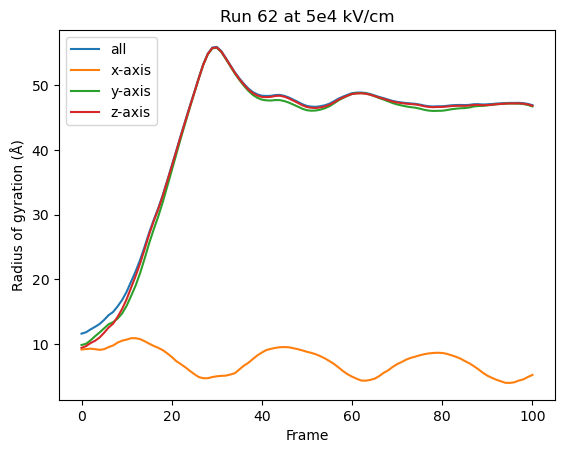

In [25]:
labels = ['all', 'x-axis', 'y-axis', 'z-axis']

plot_rogrun = 62

for col, label in zip(all_rog[plot_rogrun].results['timeseries'].T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.title(f'Run {plot_rogrun} at {efield} kV/cm')
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame')
plt.show()



Extract posdata from h5 file (lists are ordered by run)

In [26]:
cwd = f'/home/mans/moldstruct_python/E_{efield}{mds_folder}_mds'

run_dirs = os.listdir(f'{cwd}')
run_dirs.sort()
run_dirs = run_dirs[1:] #Contains all the runs (runxxx_mds)
run_dirs = sorted(run_dirs, key=extract_number)
allsim_posdata = []
print(run_dirs)
for run in run_dirs:
    
    fold_dirs = os.listdir(f'{cwd}/{run}') #Contains all the folds for that run (E_3/5e4_runxxx_0xxx_mds)
    fold_dirs.sort()    
    fold_dirs = fold_dirs[:-1]
    
    for fold in fold_dirs:
        try:
            content = (os.listdir(f'{cwd}/{run}/{fold}/'))
            content.sort()
            if content == [f'.{fold[:-4]}_exp.trr_offsets.npz', f'{fold[:-4]}.gro', f'{fold[:-4]}_exp.gro', f'{fold[:-4]}_exp.trr', 'additional_data', 'data.h5', 'ener.edr', 'kin.xvg', 'tot.xvg']:
                h5file = f'{cwd}/{run}/{fold}/data.h5'
                # Exctract the position data (unit displacement)
                with h5py.File(h5file, 'r') as file:   #how to open h5 file: h5dump name
                    group_path =f'E_{efield}{mds_folder}_mds'
                    group = file[group_path]
                    pos_data = group["unit_displacement"][:]
                pos_data = np.array(pos_data)
                allsim_posdata.append(pos_data)
            else:
                fail_replace = np.zeros(shape=(1238, 3))
                allsim_posdata.append(fail_replace)
        except Exception as e:
            print(f'There is no {fold[:-4]}: {e}')


['run0_mds', 'run1_mds', 'run2_mds', 'run3_mds', 'run4_mds', 'run5_mds', 'run6_mds', 'run7_mds', 'run8_mds', 'run9_mds', 'run10_mds', 'run11_mds', 'run12_mds', 'run13_mds', 'run14_mds', 'run15_mds', 'run16_mds', 'run17_mds', 'run18_mds', 'run19_mds', 'run20_mds', 'run21_mds', 'run22_mds', 'run23_mds', 'run24_mds', 'run25_mds', 'run26_mds', 'run27_mds', 'run28_mds', 'run29_mds', 'run30_mds', 'run31_mds', 'run32_mds', 'run33_mds', 'run34_mds', 'run35_mds', 'run36_mds', 'run37_mds', 'run38_mds', 'run39_mds', 'run40_mds', 'run41_mds', 'run42_mds', 'run43_mds', 'run44_mds', 'run45_mds', 'run46_mds', 'run47_mds', 'run48_mds', 'run49_mds', 'run50_mds', 'run51_mds', 'run52_mds', 'run53_mds', 'run54_mds', 'run55_mds', 'run56_mds', 'run57_mds', 'run58_mds', 'run59_mds', 'run60_mds', 'run61_mds', 'run62_mds', 'run63_mds', 'run64_mds', 'run65_mds', 'run66_mds', 'run67_mds', 'run68_mds', 'run69_mds', 'run70_mds', 'run71_mds', 'run72_mds', 'run73_mds', 'run74_mds', 'run75_mds', 'run76_mds', 'run77_m

Input parameters for bin_plane

In [ ]:
plane_size = 200 #Plane size 
detector_distance = 10 #Detector distance
num_bins = 50 #Number of bins (meaning how many bins that should fit the plane)


detector_eff = 1.0 # effciency of detector
axis = 0 #Where to place the detector relative to the reference frame of the datas
# 0 -> x
# 1 -> y
# 2 -> z
if axis == 0:
    axis_xyz = 'x'
elif axis == 1:
    axis_xyz = 'y'
else:
    axis_xyz = 'z'

#For image
all_imgs= []
all_hits = []
for pos_data in allsim_posdata:
    img = np.ndarray(shape=(num_bins,num_bins))
    img, nr_hits = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
    all_imgs.append(img)
    all_hits.append(nr_hits)

Mean arrays and normalization for movies and correlations

In [34]:
#To make the mean of all runs

old_list = np.array(all_imgs)  # Convert to NumPy array
new_array = old_list.reshape(100, 101, num_bins, num_bins)  # Reshape into 100 sets of 101 values each (rows are runs, columns are folds)
mean_imgs = new_array.mean(axis=0)  # Compute mean for each column
#new_mean_list = new_mean_list.tolist()  # Convert back to a Python list if needed
print(len(mean_imgs))

#Normalization for each mean map is to get an easier visualization of the explosion shape evolution in movies, 
# Since we disregard intensity differences, the brightness between frames is unaltered.
norm_imgs = []
for img in mean_imgs:
    norm_imgs.append(normalize(img))


101


Detector image

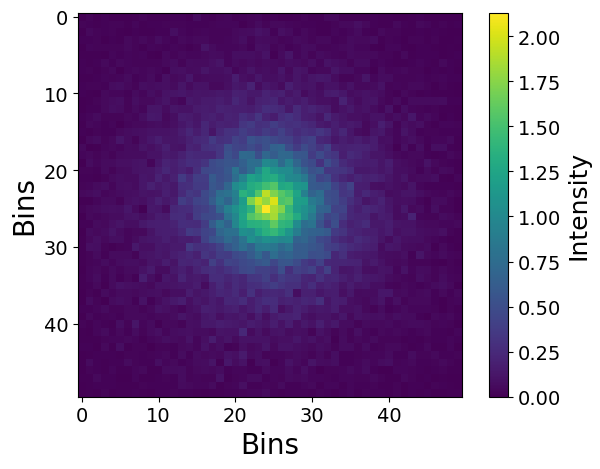

In [35]:
# For detector image
fold_image = 100
plt.imshow(mean_imgs[fold_image])
cbar = plt.colorbar()
cbar.set_label('Intensity', fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.xlabel(f'Bins', fontsize=20)
plt.ylabel(f'Bins', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'/home/mans/results/ionmaps/img_{efield}_{axis_xyz}-axis_E{fold_image}_{plane_size}_{detector_distance}_{num_bins}.png')
plt.show()

Image Crop

In [30]:
from PIL import Image

# Load the image
image_path = '/home/mans/results'
image_folder = os.listdir(f'{image_path}/ionmaps/')
os.makedirs(f'{image_path}/ionmaps_cropped', exist_ok=True)

crop_box = (107, 58, 478, 428)  # (left, upper, right, lower)

for i in image_folder:
    img = Image.open(f'{image_path}/ionmaps/{i}').convert("RGB")

    # Crop and save
    cropped_img = img.crop(crop_box)
    cropped_img.save(f"{image_path}/ionmaps_cropped/{i[:-4]}_cropped.png")


Explosionmap Movie

/home/mans/results/movies/normalized_movie_5e4__z_d10_bin50.mp4


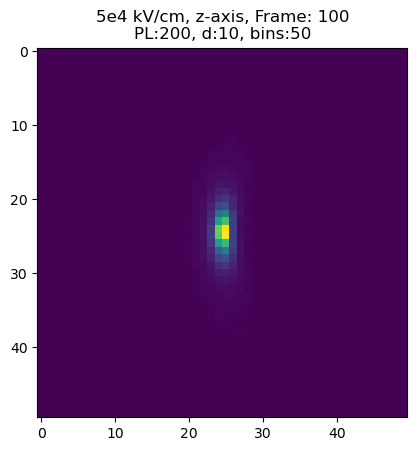

In [31]:
import matplotlib.animation as animation

cax_frame =0
# Set up the figure and axis
fig, ax = plt.subplots()
cax = ax.imshow(norm_imgs[cax_frame])
ax.set_title(f"")


# Function to update the plot for each frame
def update(frame):
    cax.set_data(norm_imgs[frame])
    ax.set_title(f"{efield} kV/cm, {axis_xyz}-axis, Frame: {frame}\nPL:{plane_size}, d:{detector_distance}, bins:{num_bins}")
    return cax,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(norm_imgs), interval=100, blit=True)

#Save the animation
save_path = f'/home/mans/results/movies/normalized_movie_{efield}_{mds_folder}_{axis_xyz}_d{detector_distance}_bin{num_bins}.mp4'
print(save_path)
saveit = input(f'Save?: ')
if saveit == 'y':
    ani.save(save_path, writer='ffmpeg', fps=10)

# Display the animation in the notebook
HTML(ani.to_jshtml())


1D Gaussian fitting

In [38]:
norm_array = np.array(norm_imgs)

def intensity_profiles(img):
    sum_x = np.sum(img, axis=0)
    sum_y = np.sum(img, axis=1)
    return sum_x, sum_y

def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

def fit_gaussian(profile):
    x = np.arange(len(profile))
    y = profile
    popt, _ = curve_fit(gaussian, x, y, p0=[np.max(y), np.argmax(y), 10])
    A, mu, sigma = popt
    return mu, sigma

#Take diameters using FWHM
def sigma_to_diameter(sigma):
    return 2.355 * sigma

#Loop over images
diameters = []
for img in norm_imgs:

    sum_x, sum_y = intensity_profiles(img)

    _, sigma_x = fit_gaussian(sum_x) #horizontal profile
    _, sigma_y = fit_gaussian(sum_y) #vertical profile
    
    diameter_x = sigma_to_diameter(sigma_x)
    diameter_y = sigma_to_diameter(sigma_y)
    
    diameters.append((diameter_x, diameter_y))




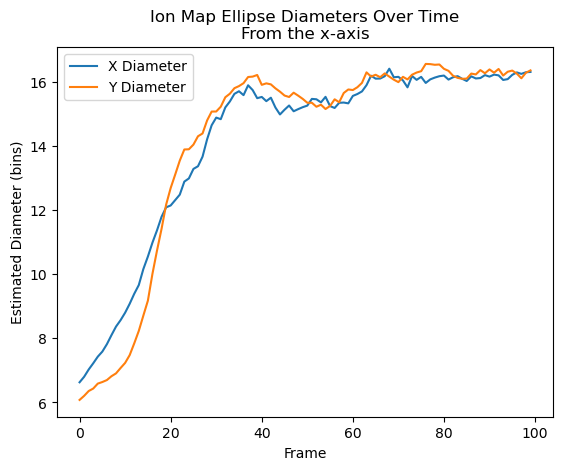

In [39]:
#Plot diameters
diameters = np.array(diameters)
plt.plot(diameters[0:100, 0], label='X Diameter')
plt.plot(diameters[0:100, 1], label='Y Diameter')
plt.legend()
plt.title(f'Ion Map Ellipse Diameters Over Time\nFrom the {axis_xyz}-axis')
plt.xlabel('Frame')
plt.ylabel('Estimated Diameter (bins)')
plt.show()

RoG to Diameter relationship

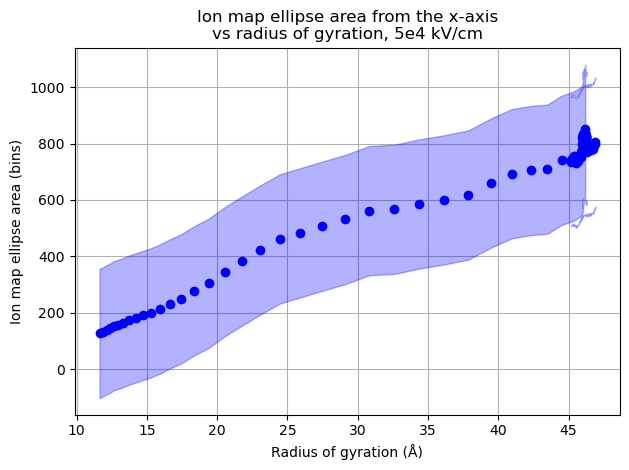

In [47]:
#Mean diameter
diameters = np.array(diameters)
mean_diameters = diameters
diameters_std = np.std(diameters, axis=0)

mean_diameters_x = mean_diameters[:,0]
mean_diameters_y = mean_diameters[:,1]

ellipse_area_all = []
ellipse_area_mean = []
for i in range(len(diameters)):
    ellipse_area_all.append(math.pi*diameters[i,0]*diameters[i,1])  
    ellipse_area_mean.append(math.pi*mean_diameters[i,0]*mean_diameters[i,1])

mean_rog_repeat = []
for j in range(100):
    for i in mean_rog:
        mean_rog_repeat.append(i)


#################################### MEAN RUNS WITH STD ########################################
ellipse_std = np.std(ellipse_area_all, axis=0)

plt.scatter(mean_rog, ellipse_area_mean, label='inv ellipse area', color='blue')
plt.fill_between(mean_rog, ellipse_area_mean - ellipse_std, ellipse_area_mean + ellipse_std, color='blue', alpha=0.3, label='standard deviation')
plt.title(f'Ion map ellipse area from the {axis_xyz}-axis\nvs radius of gyration, {efield} kV/cm')
plt.xlabel('Radius of gyration (Å)')
plt.ylabel('Ion map ellipse area (bins)')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.tight_layout()
plt.show()

Number of detector hits vs RoG

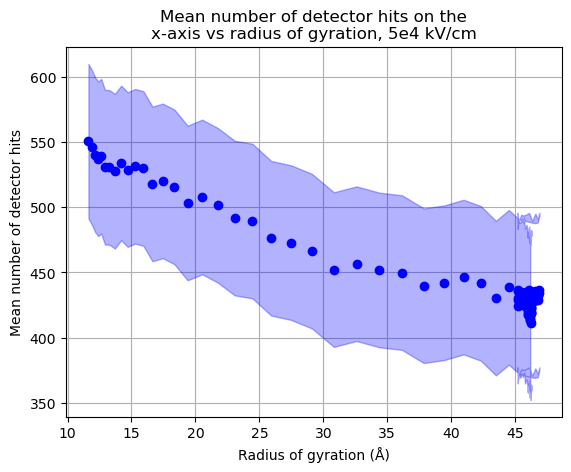

In [48]:
all_hits = np.array(all_hits)
array_hits = all_hits.reshape(100, 101)
mean_hits = np.mean(array_hits, axis=0)
hits_std = np.std(all_hits, axis=0)


plt.scatter(mean_rog, mean_hits, label=f'Hits', color='blue')
plt.fill_between(mean_rog, mean_hits - hits_std, mean_hits + hits_std, color= 'blue', alpha=0.3, label='Standard deviation')
plt.title(f'Mean number of detector hits on the\n{axis_xyz}-axis vs radius of gyration, {efield} kV/cm')
plt.xlabel('Radius of gyration (Å)')
plt.ylabel('Mean number of detector hits')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()